# Müşteri Kaybı Tahmini

   &ensp;<sup>Edanur Yılmaz (121521014)</sup>  
   &ensp;<sup>24.01.2025</sup>

## İçerik
• [Veri İncelemesi ve Ön İşlemesi](#Veri-İncelemesi-ve-Ön-İşlemesi)  
• [1.Multi-layer Perceptron Classifier](#1.Multi-layer-Perceptron-Classifier)    
    &emsp;- [Grid Search Cross-Validation](#1.1.Grid-Search-Cross-Validation)    
• [2.Decision Tree Classifier](#2.Decision-Tree-Classifier)  
    &emsp;- [Grid Search Cross-Validation](#2.1.Grid-Search-Cross-Validation)  
• [3.Random Forest Classifier](#3.Random-Forest-Classifier)    
    &emsp;- [Grid Search Cross-Validation](#3.1.Grid-Search-Cross-Validation)  
• [4.Gradient Boosting Classifier](#4.Gradient-Boosting-Classifier)  
    &emsp;- [Grid Search Cross-Validation](#4.1.Grid-Search-Cross-Validation)  
• [5.Extreme Gradient Boosting Classifier](#5.Extreme-Gradient-Boosting-Classifier)  
    &emsp;- [Grid Search Cross-Validation](#5.1.Grid-Search-Cross-Validation)

In [1]:
from warnings import filterwarnings
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,roc_curve,roc_auc_score
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [2]:
filterwarnings("ignore")

# Veri İncelemesi ve Ön İşlemesi
&ensp;<sup>[İçeriğe git.](#İçerik)</sup>

Banka müşterilerinin, bankadan ayrılıp ayrılmadığını tahmin edeceğim veri:

In [3]:
customers = pd.read_csv("Churn_Modelling.csv")
customers.isnull().sum().sum()

0

In [4]:
customers.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
customers["Exited"].unique()

array([1, 0], dtype=int64)

Bankadan ayrılmayan müşteri sayısının 7963 ve ayrılan müşteri sayısının 2037 olduğunu görüyorum.

In [6]:
customers["Exited"].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

Tahmin için anlamlı olmayan değişkenleri çıkarıyorum.

In [7]:
remove = ["RowNumber", "CustomerId", "Surname"]

customers = customers.drop(remove ,axis=1)

Kategorik 'Gender' değişkenine değer atıyorum.

In [8]:
def binary_map(x):
    return x.map({"Female" : 1,
                  "Male" : 0})

In [9]:
customers["Gender"] = binary_map(customers["Gender"])

Kategorik 'Geography' değişkenine dummy değişkenler atıyorum.

In [10]:
status = pd.get_dummies(customers["Geography"]).astype(int)
status

,France,Germany,Spain
0,1,0,0
1,0,0,1
2,1,0,0
3,1,0,0
4,0,0,1
...,...,...,...
9995,1,0,0
9996,1,0,0
9997,1,0,0
9998,0,1,0


In [11]:
customers = pd.concat([customers, status], axis=1)
customers

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain
0,619,France,1,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608,Spain,1,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,France,1,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699,France,1,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850,Spain,1,43,2,125510.82,1,1,1,79084.10,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,0,39,5,0.00,2,1,0,96270.64,0,1,0,0
9996,516,France,0,35,10,57369.61,1,1,1,101699.77,0,1,0,0
9997,709,France,1,36,7,0.00,1,0,1,42085.58,1,1,0,0
9998,772,Germany,0,42,3,75075.31,2,1,0,92888.52,1,0,1,0


In [12]:
customers.drop(["Geography"], axis=1, inplace = True)
customers

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain
0,619,1,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608,1,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,1,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699,1,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850,1,43,2,125510.82,1,1,1,79084.10,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,0,39,5,0.00,2,1,0,96270.64,0,1,0,0
9996,516,0,35,10,57369.61,1,1,1,101699.77,0,1,0,0
9997,709,1,36,7,0.00,1,0,1,42085.58,1,1,0,0
9998,772,0,42,3,75075.31,2,1,0,92888.52,1,0,1,0


Tahmin edeceğim 'Exited' değişkenini y diğer değişkenleri X olarak tanımlıyorum.

In [13]:
y = customers["Exited"]
X = customers.drop(["Exited"],axis=1)

Veriyi Train ve Test olarak ayırıyorum.   
(Tahmin edilecek değişkenin aldığı değerlerin sayısı yakın olmadığı için az bulunan değerin doğru tahmin edilmesi daha zor. Bu nedenle 'stratify=y' ile train-test ayrıştırmasında her iki değerin de hem test hem de train setinde eşit oranda bulunması sağlanabilir.)

In [14]:
customers_X_Train,customers_X_Test,customers_y_Train,customers_y_Test = train_test_split(X, y,
                                                                                 test_size=0.20,
                                                                                 #stratify=y,
                                                                                 random_state=121521014)

Bankanın kaybettiği müşteri sayısının, kaybetmediği müşteri sayısına göre çok daha az olduğu görülüyor.

In [15]:
customers["Exited"].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

Train setindeki dağılımı:  

In [16]:
dataExited_train = customers_y_Train == 1
dataRetained_train = customers_y_Train == 0

dataExited_train.sum(), dataRetained_train.sum()

(1625, 6375)

Standartlaştırma ile veriyi ölçeklendiriyorum.

In [17]:
scalerANNClass = StandardScaler()

In [18]:
customers_X_Train_scaled = scalerANNClass.fit_transform(customers_X_Train)
customers_X_Test_scaled = scalerANNClass.transform(customers_X_Test)

# 1.Multi-layer Perceptron Classifier
&ensp;<sup>[İçeriğe git.](#İçerik)</sup>

In [19]:
aNN_Class= MLPClassifier(random_state=121521014, max_iter=1000).fit(customers_X_Train_scaled, customers_y_Train)

Tahminleri ve olasılık tahminlerini alıyorum.

In [20]:
y_pred_aNN_Class_Train = aNN_Class.predict(customers_X_Train_scaled)
y_pred_aNN_Class_Test = aNN_Class.predict(customers_X_Test_scaled)

y_pred_aNN_Class_Train_proba = aNN_Class.predict_proba(customers_X_Train_scaled)
y_pred_aNN_Class_Test_proba = aNN_Class.predict_proba(customers_X_Test_scaled)

In [21]:
def confusion_matrices(conf_mat_train, conf_mat_test):
    print(" Train confusion matrix:\n", pd.DataFrame(conf_mat_train),
     "\n", "Test confusion matrix:\n", pd.DataFrame(conf_mat_test))

In [22]:
aNN_cf_train = confusion_matrix(customers_y_Train, y_pred_aNN_Class_Train)
aNN_cf_test = confusion_matrix(customers_y_Test, y_pred_aNN_Class_Test)

Confusion Matrix incelendiğinde Train için kaybedilmeyen müşeterilerden 6170'inin doğru, 205'i'nin yanlış tahmin edildiği görülüyor. Train için kaybedilen müşterilerden 663'ünün doğru ve 962'nin yanlış tahmin edildiği görülüyor. Test seti de benzer şekilde yorumlanabilir.

In [23]:
print("MLPClassifier")
aNN_cf = confusion_matrices(aNN_cf_train, aNN_cf_test)

MLPClassifier
 Train confusion matrix:
       0    1
0  6170  205
1   663  962 
 Test confusion matrix:
       0    1
0  1498   90
1   208  204


✦ Sınıfların büyüklükleri arasında dikkate alınması gereken farklılıklar olduğunda doğruluk oranı modelin performansı için anlamlı bir sonuç vermeyecektir.

In [24]:
def accuracy_scores(accuracy_score_train, accuracy_score_test):
    print(" Train accuracy score:", accuracy_score_train,
     "\n", "Test accuracy score:", accuracy_score_test)

In [25]:
aNN_acc_train = accuracy_score(customers_y_Train, y_pred_aNN_Class_Train)
aNN_acc_test = accuracy_score(customers_y_Test, y_pred_aNN_Class_Test)

Modelin Train seti için doğruluğu %89 ve Test seti için %85'tir.  

In [26]:
print("\t", "MLPClassifier")
aNN_acc = accuracy_scores(aNN_acc_train, aNN_acc_test)

	 MLPClassifier
 Train accuracy score: 0.8915 
 Test accuracy score: 0.851


In [27]:
def classification_reports(actual, predicted):
    print(classification_report(actual, predicted))

Train seti için,
- Kaybedilmeyen müşterilerin doğru tahmin edilme oranı %97 ve kaybedilmedi olarak sınıflandırılan müşterilerin doğru tahmin edilme oranı ise %90'dır. Bu iki değerden elde edilen f1-skoru %93'tür. Oldukça iyi.

- Kaybedilen müşterilerin doğru tahmin edilme oranı %59 ve kaybedildi olarak sınıflandırılan müşterilerin doğru tahmin edilme oranı ise %82'dir. Yani kaybedilen müşteriler iyi tahmin edilememekle beraber ayrılacağı tahmin edilen kişilerin gerçekten de kaybedildiği durumlar fazladır.

Modelin, sayısı az olmasından dolayı kaybedilen müşterileri tahmin etmekte kötü olması beklenilen bir durumdur.

In [28]:
print("\t"*3, "MLPClassifier Train")
aNN_report_train = classification_reports(customers_y_Train, y_pred_aNN_Class_Train)

			 MLPClassifier Train
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      6375
           1       0.82      0.59      0.69      1625

    accuracy                           0.89      8000
   macro avg       0.86      0.78      0.81      8000
weighted avg       0.89      0.89      0.88      8000



Test seti tahminleri daha kötüdür. Özellikle kaybedilen müşterilerin doğru tahmin edilme oranının %50 olması çok kötüdür. Rastgele tahminde bulunmakla aynı anlamlılığa sahiptir. Kaybedildi olarak sınıflandırılan müşterilerin doğru tahmin edilme oranı ise %69'dur. Genel olarak kötü bir performansa sahiptir.

In [29]:
print("\t"*3, "MLPClassifier Test")
aNN_report_test = classification_reports(customers_y_Test, y_pred_aNN_Class_Test)

			 MLPClassifier Test
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1588
           1       0.69      0.50      0.58       412

    accuracy                           0.85      2000
   macro avg       0.79      0.72      0.74      2000
weighted avg       0.84      0.85      0.84      2000



In [30]:
def roc_auc(title, actual, pred, pred_proba):
    logit_roc_auc = roc_auc_score(actual, pred)
    fpr, tpr, thresholds = roc_curve(actual, pred_proba[:,1])
    plt.figure()
    plt.plot(fpr,tpr,label = 'AUC(area = %0.2f)' % logit_roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.01,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    return plt.show()

Altta kalan alan train seti için %78 ve test seti için ise %72'dir. Tahminler genel olarak çok kötü değil.  
(Bu değeri düşüren kaybedilen müşterilerin doğru tahmin edilememesidir. Sadece ROC eğrisine bakarak modelin bu durumu tahmin etmekte ne kadar kötü olduğu görülemez.)

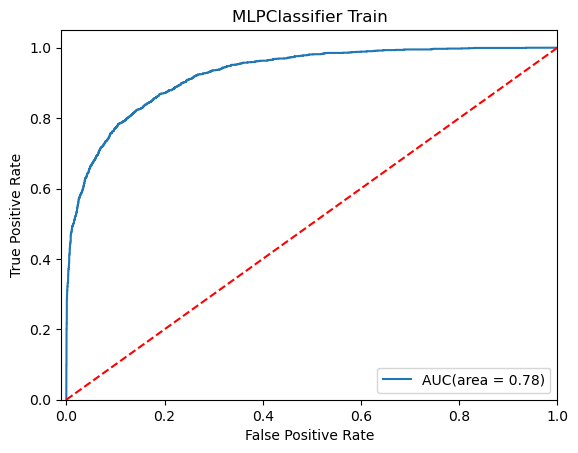

In [31]:
aNN_roc_train = roc_auc("MLPClassifier Train",customers_y_Train, y_pred_aNN_Class_Train, y_pred_aNN_Class_Train_proba)

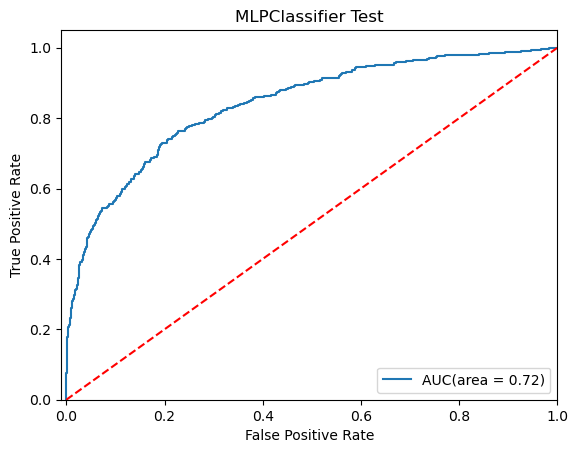

In [32]:
aNN_roc_test = roc_auc("MLPClassifier Test", customers_y_Test, y_pred_aNN_Class_Test, y_pred_aNN_Class_Test_proba)

#### 1.1.Grid Search Cross Validation
&nbsp;<sup>[İçeriğe git.](#İçerik)</sup>

MLPClassifier hiperparametrelerinden bazılarını belirliyorum.

In [33]:
#?aNN_Class
aNN_Class_params = {"alpha":[0.001, 0.1, 0.15],
                    "learning_rate_init":[0.001, 0.01, 0.02]}

In [34]:
aNN_ClassfCV = MLPClassifier(random_state=121521014)

En iyi parameterleri bulmak için 5 foldluk GridSearch yapıyorum.

In [47]:
aNN_Class_CVGS = GridSearchCV(aNN_ClassfCV,
                              aNN_Class_params,
                              cv=10,
                              n_jobs=-1,
                              verbose=2).fit(customers_X_Train_scaled, customers_y_Train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


In [48]:
aNN_Class_CVGS.best_params_, aNN_Class_CVGS.best_score_

({'alpha': 0.1, 'learning_rate_init': 0.02}, 0.8643750000000001)

En iyi olarak seçilen parametrelerle yeniden model kuruyorum.

In [49]:
aNN_Class_CVGS_tuned = MLPClassifier(#random_state=1215212014,
                                     alpha=aNN_Class_CVGS.best_params_["alpha"],
                                     learning_rate_init=aNN_Class_CVGS.best_params_["learning_rate_init"]).fit(customers_X_Train_scaled,customers_y_Train)

Tahminleri ve olasılık tahminlerini alıyorum.

In [50]:
CVGS_pred_aNN_Class_Train = aNN_Class_CVGS_tuned.predict(customers_X_Train_scaled)
CVGS_pred_aNN_Class_Test = aNN_Class_CVGS_tuned.predict(customers_X_Test_scaled)

CVGS_pred_aNN_Class_Train_proba = aNN_Class_CVGS_tuned.predict_proba(customers_X_Train_scaled)
CVGS_pred_aNN_Class_Test_proba = aNN_Class_CVGS_tuned.predict_proba(customers_X_Test_scaled)

In [51]:
CVGS_aNN_cf_train = confusion_matrix(customers_y_Train, CVGS_pred_aNN_Class_Train)
CVGS_aNN_cf_test = confusion_matrix(customers_y_Test, CVGS_pred_aNN_Class_Test)

In [52]:
print("CVGS Tuned MLPClassifier")
CVGS_aNN_cf = confusion_matrices(CVGS_aNN_cf_train, CVGS_aNN_cf_test)

CVGS Tuned MLPClassifier
 Train confusion matrix:
       0    1
0  6124  251
1   779  846 
 Test confusion matrix:
       0    1
0  1501   87
1   208  204


In [53]:
CVGS_aNN_acc_train = accuracy_score(customers_y_Train, CVGS_pred_aNN_Class_Train)
CVGS_aNN_acc_test = accuracy_score(customers_y_Test, CVGS_pred_aNN_Class_Test)

Farklı parametrelerle yaptığım denemelerde de model performansını iyileştiremedim. Bu durum için train seti perfromansı kötüleşirken, test seti performansının çok az arttığını görebiliyorum. İyi bir şekilde tune edemedim.

In [54]:
print(" "*2, "CVGS Tuned MLPClassifier")
aNN_acc = accuracy_scores(CVGS_aNN_acc_train, CVGS_aNN_acc_test)

   CVGS Tuned MLPClassifier
 Train accuracy score: 0.87125 
 Test accuracy score: 0.8525


In [55]:
print("\t"*2, "CVGS Tuned MLPClassifier Train")
CVGS_aNN_report_train = classification_reports(customers_y_Train, CVGS_pred_aNN_Class_Train)

		 CVGS Tuned MLPClassifier Train
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      6375
           1       0.77      0.52      0.62      1625

    accuracy                           0.87      8000
   macro avg       0.83      0.74      0.77      8000
weighted avg       0.86      0.87      0.86      8000



In [56]:
print("\t"*2, "CVGS Tuned MLPClassifier Test")
CVGS_aNN_report_test = classification_reports(customers_y_Test, CVGS_pred_aNN_Class_Test)

		 CVGS Tuned MLPClassifier Test
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1588
           1       0.70      0.50      0.58       412

    accuracy                           0.85      2000
   macro avg       0.79      0.72      0.75      2000
weighted avg       0.84      0.85      0.84      2000



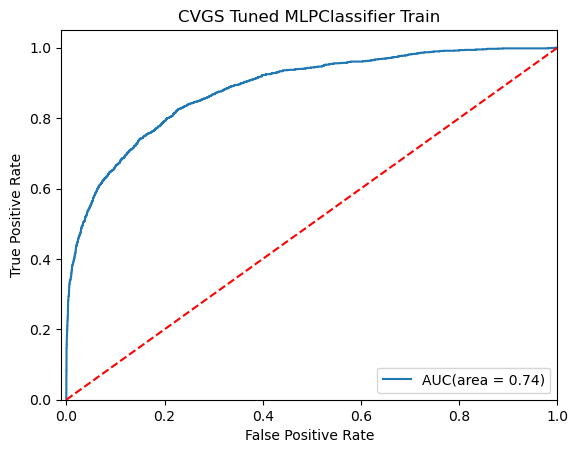

In [57]:
CVGS_aNN_roc_train = roc_auc("CVGS Tuned MLPClassifier Train", customers_y_Train, CVGS_pred_aNN_Class_Train, CVGS_pred_aNN_Class_Train_proba)

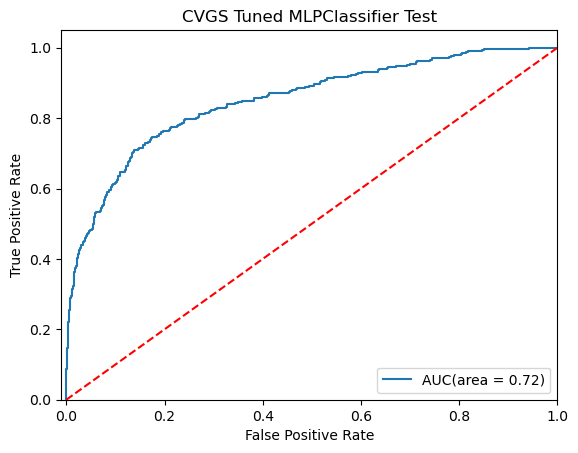

In [58]:
CVGS_aNN_roc_test = roc_auc("CVGS Tuned MLPClassifier Test", customers_y_Test, CVGS_pred_aNN_Class_Test, CVGS_pred_aNN_Class_Test_proba)

# 2.Decision Tree Classifier
&ensp;<sup>[İçeriğe git.](#İçerik)</sup>

In [124]:
dTree_Class = DecisionTreeClassifier(random_state=121521014).fit(customers_X_Train,customers_y_Train)

In [1]:
def feature_importances(title, model, X):
    feature_imp = pd.Series(model.feature_importances_,
                        index=X.columns).sort_values(ascending=False)
    
    sns.barplot(x=feature_imp, y=feature_imp.index, palette='colorblind')
    plt.xlabel('Değişken Önem Skorları')
    plt.ylabel('Değişkenler')
    plt.title(title)
    return plt.show()

Decision Tree modeli için değişkenlerin önemliliklerine bakıyorum.

Modelde en etkili değişkenin 'Age' ve en önemsiz değişkenin ise coğrafya değişkeninin bir parçası olan 'Spain' olduğunu görebiliyorum.  
Önemi çok düşük olan değerler çıkarılıp yeniden model kurulabilir.

C:\Users\Arzu YILMAZ\AppData\Local\Temp\ipykernel_7032\3902935333.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_imp, y=feature_imp.index, palette='colorblind')


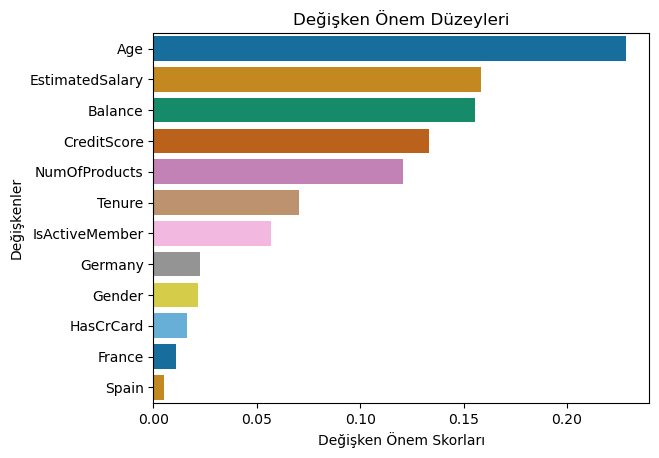

In [126]:
dTree_features = feature_importances("DecisionTreeClassifier", dTree_Class, customers_X_Train)

Tahminleri ve olasılık tahminlerini alıyorum.

In [127]:
y_pred_dTree_Class_Train = dTree_Class.predict(customers_X_Train)
y_pred_dTree_Class_Test = dTree_Class.predict(customers_X_Test)

y_pred_dTree_Class_Train_proba = dTree_Class.predict_proba(customers_X_Train)
y_pred_dTree_Class_Test_proba = dTree_Class.predict_proba(customers_X_Test)

In [128]:
dTree_cf_train = confusion_matrix(customers_y_Train, y_pred_dTree_Class_Train)
dTree_cf_test = confusion_matrix(customers_y_Test, y_pred_dTree_Class_Test)

In [129]:
print("DecisionTreeClassifier")
dTree_cf = confusion_matrices(dTree_cf_train, dTree_cf_test)

 Train confusion matrix:
       0     1
0  6375     0
1     0  1625 
 Test confusion matrix:
       0    1
0  1365  223
1   199  213
						 DecisionTreeClassifier


In [130]:
dTree_acc_train = accuracy_score(customers_y_Train, y_pred_dTree_Class_Train)
dTree_acc_test = accuracy_score(customers_y_Test, y_pred_dTree_Class_Test)

In [131]:
aNN_acc = accuracy_scores(aNN_acc_train, aNN_acc_test)
print("\t", "DecisionTreeClassifier")

 Train accuracy score: 0.8915 
 Test accuracy score: 0.851
						 DecisionTreeClassifier


Bir overfit durumu vardır.

In [132]:
print("\t"*3, "DecisionTreeClassifier Train")
dTree_report_train = classification_reports(customers_y_Train, y_pred_dTree_Class_Train)

			 DecisionTreeClassifier Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6375
           1       1.00      1.00      1.00      1625

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



Test seti performansı kötüdür. Kaybedilen müşterileri doğru tahmin etmede rastgele tahmin kadar bir performansa sahiptir.

In [133]:
print("\t"*3, "DecisionTreeClassifier Test")
dTree_report_test = classification_reports(customers_y_Test, y_pred_dTree_Class_Test)

			 DecisionTreeClassifier Test
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1588
           1       0.49      0.52      0.50       412

    accuracy                           0.79      2000
   macro avg       0.68      0.69      0.68      2000
weighted avg       0.79      0.79      0.79      2000



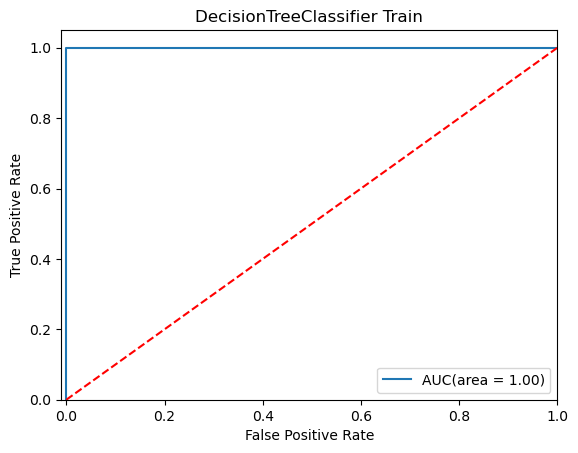

In [134]:
dTree_roc_train = roc_auc("DecisionTreeClassifier Train",customers_y_Train, y_pred_dTree_Class_Train, y_pred_dTree_Class_Train_proba)

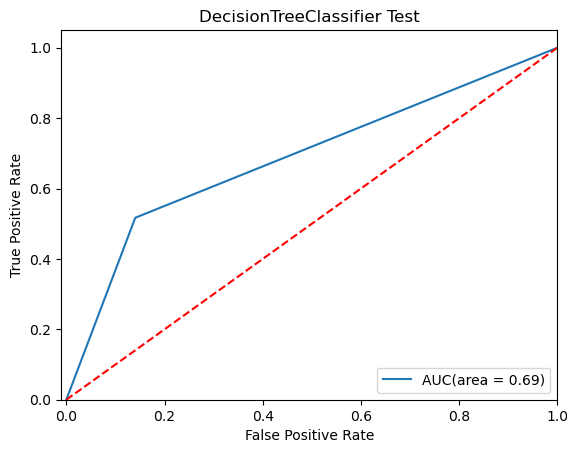

In [198]:
dTree_roc_test = roc_auc("DecisionTreeClassifier Test",customers_y_Test, y_pred_dTree_Class_Test, y_pred_dTree_Class_Test_proba)

#### 2.1.Grid Search Cross Validation
&nbsp;<sup>[İçeriğe git.](#İçerik)</sup>

DecisionTreeClassifier hiperparametrelerinden bazılarını belirliyorum.

In [139]:
#?dTree_Class
dTree_Class_params = {"max_depth": [1, 5, 6, 7, None],
                      "min_samples_split": [2, 3, 8, 10, 12]}

In [140]:
dTree_ClassfCV = DecisionTreeClassifier(random_state=121521014)

En iyi parameterleri bulmak için 10 foldluk bir GridSearch yapıyorum.

In [141]:
dTree_Class_CVGS = GridSearchCV(dTree_ClassfCV, dTree_Class_params,
                              cv=10,
                              n_jobs=-1,
                              verbose=2).fit(customers_X_Train, customers_y_Train)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


In [142]:
dTree_Class_CVGS.best_params_

{'max_depth': 6, 'min_samples_split': 8}

En iyi olarak seçilen parametrelerle yeniden model kuruyorum.

In [143]:
dTree_Class_CVGS_tuned = DecisionTreeClassifier(#random_state=121521014,
                                                max_depth=dTree_Class_CVGS.best_params_["max_depth"],
                                                min_samples_split=dTree_Class_CVGS.best_params_["min_samples_split"]).fit(customers_X_Train,customers_y_Train)

Tahminleri ve olasılık tahminlerini alıyorum.

In [144]:
CVGS_pred_dTree_Class_Train = dTree_Class_CVGS_tuned.predict(customers_X_Train)
CVGS_pred_dTree_Class_Test = dTree_Class_CVGS_tuned.predict(customers_X_Test)

CVGS_pred_dTree_Class_Train_proba = dTree_Class_CVGS_tuned.predict_proba(customers_X_Train)
CVGS_pred_dTree_Class_Test_proba = dTree_Class_CVGS_tuned.predict_proba(customers_X_Test)

In [145]:
CVGS_dTree_cf_train = confusion_matrix(customers_y_Train, CVGS_pred_dTree_Class_Train)
CVGS_dTree_cf_test = confusion_matrix(customers_y_Test, CVGS_pred_dTree_Class_Test)

In [153]:
print("CVGS Tuned DecisionTreeClassifier")
CVGS_dTree_cf = confusion_matrices(CVGS_dTree_cf_train, CVGS_dTree_cf_test)

CVGS Tuned DecisionTreeClassifier
 Train confusion matrix:
       0    1
0  6210  165
1   877  748 
 Test confusion matrix:
       0    1
0  1522   66
1   245  167


In [147]:
CVGS_dTree_acc_train = accuracy_score(customers_y_Train, CVGS_pred_dTree_Class_Train)
CVGS_dTree_acc_test = accuracy_score(customers_y_Test, CVGS_pred_dTree_Class_Test)

In [155]:
print("CVGS Tuned DecisionTreeClassifier")
dTree_acc = accuracy_scores(CVGS_dTree_acc_train, CVGS_dTree_acc_test)

CVGS Tuned DecisionTreeClassifier
 Train accuracy score: 0.86975 
 Test accuracy score: 0.8445


Model tune edildiğinde overfit durumu ortadan kalktı fakat kaybedilen müşterilerin doğru tahmin edilme oranı oldukça düşük.

In [185]:
print(" "*13, "CVGS Tuned DecisionTreeClassifier Train")
CVGS_dTree_report_train = classification_reports(customers_y_Train, CVGS_pred_dTree_Class_Train)

              CVGS Tuned DecisionTreeClassifier Train
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      6375
           1       0.82      0.46      0.59      1625

    accuracy                           0.87      8000
   macro avg       0.85      0.72      0.76      8000
weighted avg       0.86      0.87      0.85      8000



Test setinde de aynı şekilde kaybedilen müşterilerin doğru tahmin edilme oranı oldukça düşük fakat ayrılacağı tahmin edilen müşterilerin doğru tespit edilme oranı artmıştır.

In [186]:
print(" "*13, "CVGS Tuned DecisionTreeClassifier Test")
CVGS_dTree_report_test = classification_reports(customers_y_Test, CVGS_pred_dTree_Class_Test)

              CVGS Tuned DecisionTreeClassifier Test
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1588
           1       0.72      0.41      0.52       412

    accuracy                           0.84      2000
   macro avg       0.79      0.68      0.71      2000
weighted avg       0.83      0.84      0.83      2000



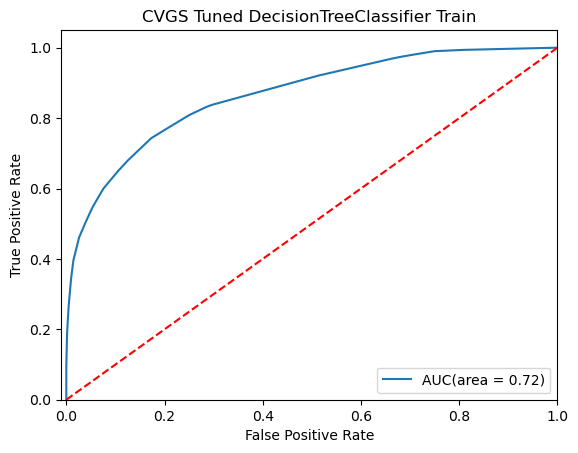

In [151]:
CVGS_dTree_roc_train = roc_auc("CVGS Tuned DecisionTreeClassifier Train", customers_y_Train, CVGS_pred_dTree_Class_Train, CVGS_pred_dTree_Class_Train_proba)

Presicion değerinin artışı grafikten de görülebiliyor.

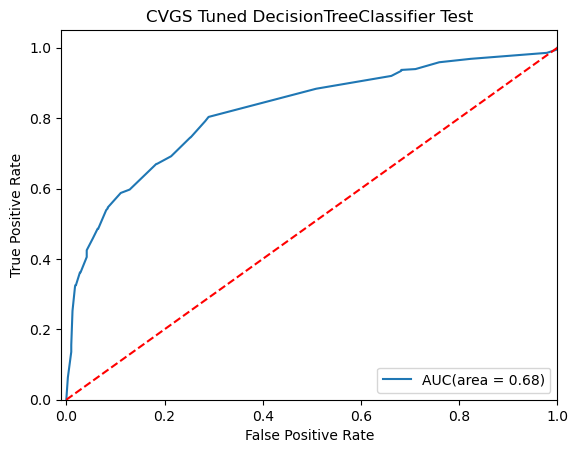

In [152]:
CVGS_dTree_roc_test = roc_auc("CVGS Tuned DecisionTreeClassifier Test", customers_y_Test, CVGS_pred_dTree_Class_Test, CVGS_pred_dTree_Class_Test_proba)

# 3.Random Forest Classifier
&ensp;<sup>[İçeriğe git.](#İçerik)</sup>

In [219]:
RndF_Class = RandomForestClassifier(random_state=121521014).fit(customers_X_Train, customers_y_Train)

Tahminleri ve olasılık tahminlerini alıyorum.

In [220]:
y_pred_RndF_Class_Train = RndF_Class.predict(customers_X_Train)
y_pred_RndF_Class_Test = RndF_Class.predict(customers_X_Test)

y_pred_RndF_Class_Train_proba = RndF_Class.predict_proba(customers_X_Train)
y_pred_RndF_Class_Test_proba = RndF_Class.predict_proba(customers_X_Test)

In [221]:
RndF_cf_train = confusion_matrix(customers_y_Train, y_pred_RndF_Class_Train)
RndF_cf_test = confusion_matrix(customers_y_Test, y_pred_RndF_Class_Test)

In [222]:
print("RandomForestClassifier")
RndF_cf = confusion_matrices(RndF_cf_train, RndF_cf_test)

						 RandomForestClassifier
 Train confusion matrix:
       0     1
0  6375     0
1     0  1625 
 Test confusion matrix:
       0    1
0  1523   65
1   219  193


In [223]:
RndF_acc_train = accuracy_score(customers_y_Train, y_pred_RndF_Class_Train)
RndF_acc_test = accuracy_score(customers_y_Test, y_pred_RndF_Class_Test)

In [224]:
print("\t", "RandomForestClassifier")
RndF_acc = accuracy_scores(RndF_acc_train, RndF_acc_test)

						 RandomForestClassifier
 Train accuracy score: 1.0 
 Test accuracy score: 0.858


Overfit durumu vardır.

In [225]:
print("\t"*3, "RandomForestClassifier Train")
RndF_report_train = classification_reports(customers_y_Train, y_pred_RndF_Class_Train)

			 RandomForestClassifier Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6375
           1       1.00      1.00      1.00      1625

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



Test seti performansı kötüdür. Kaybedilen müşterileri doğru tahmin etmede rastgele tahminden daha düşük bir performansa sahiptir.

In [226]:
print("\t"*3, "RandomForestClassifier Test")
RndF_report_test = classification_reports(customers_y_Test, y_pred_RndF_Class_Test)

			 RandomForestClassifier Test
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1588
           1       0.75      0.47      0.58       412

    accuracy                           0.86      2000
   macro avg       0.81      0.71      0.75      2000
weighted avg       0.85      0.86      0.84      2000



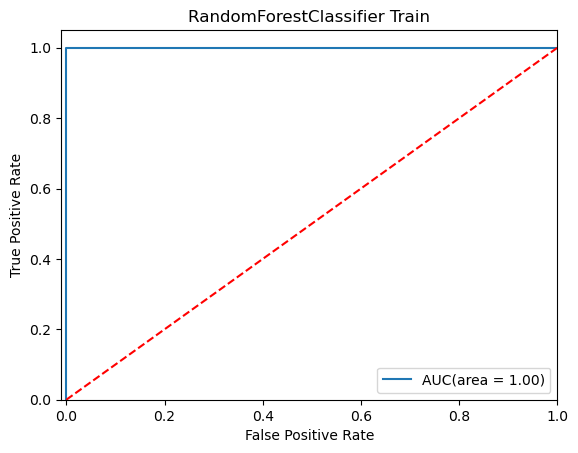

In [227]:
RndF_roc_train = roc_auc("RandomForestClassifier Train",customers_y_Train, y_pred_RndF_Class_Train, y_pred_RndF_Class_Train_proba)

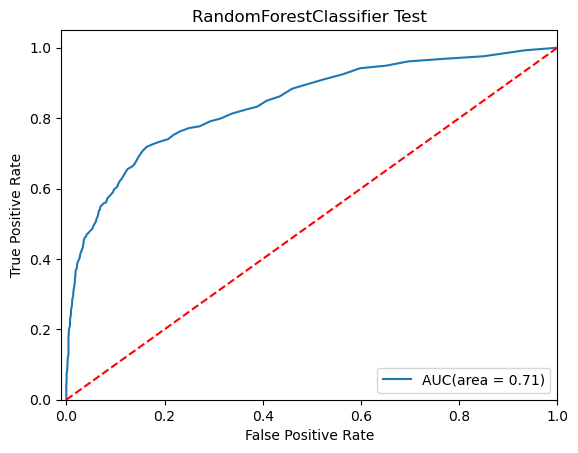

In [228]:
RndF_roc_test = roc_auc("RandomForestClassifier Test",customers_y_Test, y_pred_RndF_Class_Test, y_pred_RndF_Class_Test_proba)

#### 3.1.Grid Search Cross Validation
&nbsp;<sup>[İçeriğe git.](#İçerik)</sup>

RandomForestClassifier hiperparametrelerinden bazılarını belirliyorum.

In [249]:
#?RndF_Class
RndF_Class_params = {"n_estimators":[100, 300, 550],
                     "max_features": ['sqrt', 'log2', None],
                     "min_samples_split": [2, 4, 5, 6]}

In [250]:
RndF_ClassfCV = RandomForestClassifier(random_state=121521014)

En iyi parameterleri bulmak için 5 foldluk bir GridSearch yapıyorum.

In [251]:
RndF_Class_CVGS = GridSearchCV(RndF_ClassfCV, 
                            RndF_Class_params,
                            cv=5,
                            n_jobs=-1,
                            verbose=2).fit(customers_X_Train, customers_y_Train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [252]:
RndF_Class_CVGS.best_params_, RndF_Class_CVGS.best_score_

({'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 550},
 0.86725)

En iyi olarak seçilen parametrelerle yeniden model kuruyorum.

In [253]:
RndF_Class_CVGS_tuned = RandomForestClassifier(#random_state=121521014,
                                               n_estimators=RndF_Class_CVGS.best_params_["n_estimators"],
                                               max_features=RndF_Class_CVGS.best_params_["max_features"],
                                               min_samples_split=RndF_Class_CVGS.best_params_["min_samples_split"]).fit(customers_X_Train, customers_y_Train)

Tahminleri ve olasılık tahminlerini alıyorum.

In [254]:
CVGS_pred_RndF_Class_Train = RndF_Class_CVGS_tuned.predict(customers_X_Train)
CVGS_pred_RndF_Class_Test = RndF_Class_CVGS_tuned.predict(customers_X_Test)

CVGS_pred_RndF_Class_Train_proba = RndF_Class_CVGS_tuned.predict_proba(customers_X_Train)
CVGS_pred_RndF_Class_Test_proba = RndF_Class_CVGS_tuned.predict_proba(customers_X_Test)

In [255]:
CVGS_RndF_cf_train = confusion_matrix(customers_y_Train, CVGS_pred_RndF_Class_Train)
CVGS_RndF_cf_test = confusion_matrix(customers_y_Test, CVGS_pred_RndF_Class_Test)

In [256]:
print("CVGS Tuned RandomForestClassifier")
CVGS_RndF_cf = confusion_matrices(CVGS_RndF_cf_train, CVGS_RndF_cf_test)

CVGS Tuned RandomForestClassifier
 Train confusion matrix:
       0     1
0  6362    13
1   188  1437 
 Test confusion matrix:
       0    1
0  1521   67
1   213  199


In [257]:
CVGS_RndF_acc_train = accuracy_score(customers_y_Train, CVGS_pred_RndF_Class_Train)
CVGS_RndF_acc_test = accuracy_score(customers_y_Test, CVGS_pred_RndF_Class_Test)

In [258]:
print("CVGS Tuned RandomForestClassifier")
RndF_acc = accuracy_scores(CVGS_RndF_acc_train, CVGS_RndF_acc_test)

CVGS Tuned RandomForestClassifier
 Train accuracy score: 0.974875 
 Test accuracy score: 0.86


Model tune edildiğinde overfit durumu ortadan kalkmadı.

In [259]:
print(" "*13, "CVGS Tuned RandomForestClassifier Train")
CVGS_RndF_report_train = classification_reports(customers_y_Train, CVGS_pred_RndF_Class_Train)

              CVGS Tuned RandomForestClassifier Train
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      6375
           1       0.99      0.88      0.93      1625

    accuracy                           0.97      8000
   macro avg       0.98      0.94      0.96      8000
weighted avg       0.98      0.97      0.97      8000



Test setinde, kaybedilen müşterilerin doğru tahmin edilme oranı oldukça düşük fakat model performansı çok az iyileşmiştir.

In [260]:
print(" "*13, "CVGS Tuned RandomForestClassifier Test")
CVGS_RndF_report_test = classification_reports(customers_y_Test, CVGS_pred_RndF_Class_Test)

              CVGS Tuned RandomForestClassifier Test
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1588
           1       0.75      0.48      0.59       412

    accuracy                           0.86      2000
   macro avg       0.81      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000



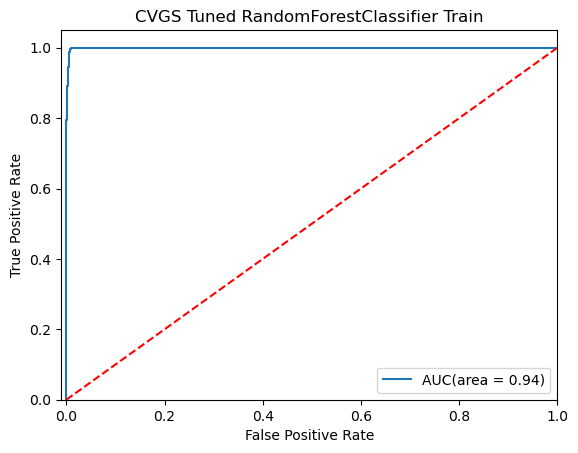

In [261]:
CVGS_RndF_roc_train = roc_auc("CVGS Tuned RandomForestClassifier Train", customers_y_Train, CVGS_pred_RndF_Class_Train, CVGS_pred_RndF_Class_Train_proba)

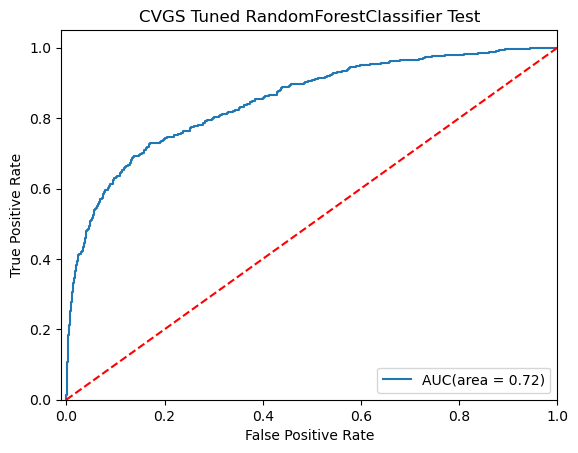

In [262]:
CVGS_RndF_roc_test = roc_auc("CVGS Tuned RandomForestClassifier Test", customers_y_Test, CVGS_pred_RndF_Class_Test, CVGS_pred_RndF_Class_Test_proba)

# 4.Gradient Boosting Classifier
&ensp;<sup>[İçeriğe git.](#İçerik)</sup>

In [263]:
gB_Class = GradientBoostingClassifier(random_state=121521014).fit(customers_X_Train, customers_y_Train)

Tahminleri ve olasılık tahminlerini alıyorum.

In [264]:
y_pred_gB_Class_Train = gB_Class.predict(customers_X_Train)
y_pred_gB_Class_Test = gB_Class.predict(customers_X_Test)

y_pred_gB_Class_Train_proba = gB_Class.predict_proba(customers_X_Train)
y_pred_gB_Class_Test_proba = gB_Class.predict_proba(customers_X_Test)

In [265]:
gB_cf_train = confusion_matrix(customers_y_Train, y_pred_gB_Class_Train)
gB_cf_test = confusion_matrix(customers_y_Test, y_pred_gB_Class_Test)

In [266]:
print("" , "GradientBoostingClassifier")
gB_cf = confusion_matrices(gB_cf_train, gB_cf_test)

 GradientBoostingClassifier
 Train confusion matrix:
       0    1
0  6185  190
1   808  817 
 Test confusion matrix:
       0    1
0  1522   66
1   213  199


In [267]:
gB_acc_train = accuracy_score(customers_y_Train, y_pred_gB_Class_Train)
gB_acc_test = accuracy_score(customers_y_Test, y_pred_gB_Class_Test)

In [268]:
print("\t"*2 , "GradientBoostingClassifier")
gB_acc = accuracy_scores(gB_acc_train, gB_acc_test)

		 GradientBoostingClassifier
 Train accuracy score: 0.87525 
 Test accuracy score: 0.8605


Train seti için modelin performansı, kaybedilen müşterileri doğru tahmin etmede rastgele bir tahmin kadar iyidir.

In [269]:
print("\t"*2, "GradientBoostingClassifier Train")
gB_report_train = classification_reports(customers_y_Train, y_pred_gB_Class_Train)

		 GradientBoostingClassifier Train
              precision    recall  f1-score   support

           0       0.88      0.97      0.93      6375
           1       0.81      0.50      0.62      1625

    accuracy                           0.88      8000
   macro avg       0.85      0.74      0.77      8000
weighted avg       0.87      0.88      0.86      8000



Test seti performansı kötüdür. Kaybedilen müşterileri doğru tahmin etmede rastgele tahminden daha düşük bir performansa sahiptir.

In [270]:
print("\t"*2, "GradientBoostingClassifier Test")
gB_report_test = classification_reports(customers_y_Test, y_pred_gB_Class_Test)

		 GradientBoostingClassifier Test
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1588
           1       0.75      0.48      0.59       412

    accuracy                           0.86      2000
   macro avg       0.81      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000



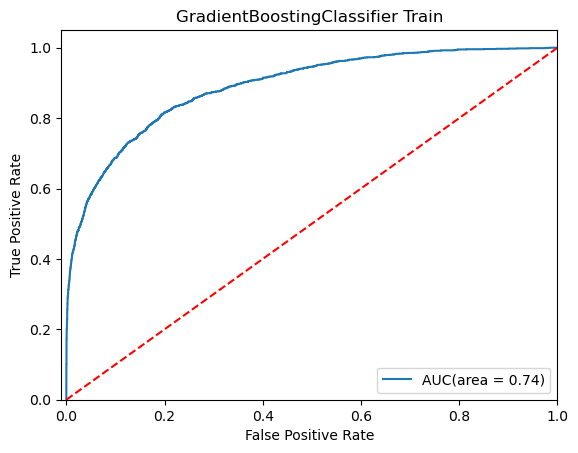

In [271]:
gB_roc_train = roc_auc("GradientBoostingClassifier Train", customers_y_Train, y_pred_gB_Class_Train, y_pred_gB_Class_Train_proba)

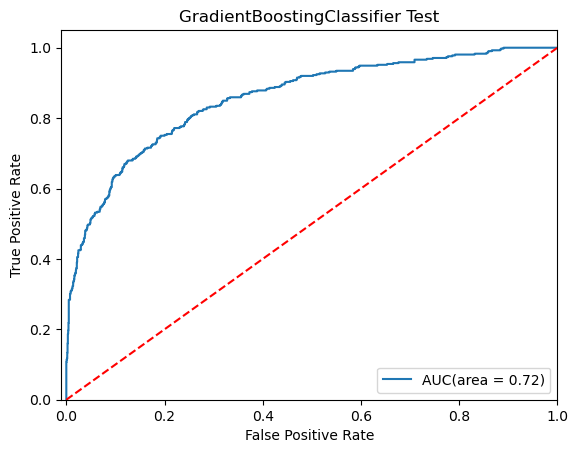

In [272]:
gB_roc_test = roc_auc("GradientBoostingClassifier Test", customers_y_Test, y_pred_gB_Class_Test, y_pred_gB_Class_Test_proba)

#### 4.1.Grid Search Cross Validation
&nbsp;<sup>[İçeriğe git.](#İçerik)</sup>

GradientBoostingClassifier hiperparametrelerinden bazılarını belirliyorum.

In [301]:
#?gB_Class
gB_Class_params = {"subsample":[ 0.1, 0.2, 0.3],
                   "n_estimators":[100, 110, 150],
                   "criterion": ['friedman_mse', 'squared_error']}

In [302]:
gB_ClassfCV = GradientBoostingClassifier(random_state=121521014)

En iyi parameterleri bulmak için 5 foldluk bir GridSearch yapıyorum.

In [303]:
gB_Class_CVGS = GridSearchCV(gB_ClassfCV, 
                             gB_Class_params,
                             cv=5,
                             n_jobs=-1,
                             verbose=2).fit(customers_X_Train, customers_y_Train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [304]:
gB_Class_CVGS.best_params_, gB_Class_CVGS.best_score_ 

({'criterion': 'squared_error', 'n_estimators': 100, 'subsample': 0.3},
 0.866875)

En iyi olarak seçilen parametrelerle yeniden model kuruyorum.

In [305]:
gB_Class_CVGS_tuned = GradientBoostingClassifier(#random_state=121521014,
                                                 subsample=gB_Class_CVGS.best_params_["subsample"],
                                                 n_estimators=gB_Class_CVGS.best_params_["n_estimators"],
                                                 criterion=gB_Class_CVGS.best_params_["criterion"]).fit(customers_X_Train, customers_y_Train)

Tahminleri ve olasılık tahminlerini alıyorum.

In [306]:
CVGS_pred_gB_Class_Train = gB_Class_CVGS_tuned.predict(customers_X_Train)
CVGS_pred_gB_Class_Test = gB_Class_CVGS_tuned.predict(customers_X_Test)

CVGS_pred_gB_Class_Train_proba = gB_Class_CVGS_tuned.predict_proba(customers_X_Train)
CVGS_pred_gB_Class_Test_proba = gB_Class_CVGS_tuned.predict_proba(customers_X_Test)

In [307]:
CVGS_gB_cf_train = confusion_matrix(customers_y_Train, CVGS_pred_gB_Class_Train)
CVGS_gB_cf_test = confusion_matrix(customers_y_Test, CVGS_pred_gB_Class_Test)

In [309]:
print("CVGS Tuned GradientBoostingClassifier")
CVGS_gB_cf = confusion_matrices(CVGS_gB_cf_train, CVGS_gB_cf_test)

CVGS Tuned GradientBoostingClassifier
 Train confusion matrix:
       0    1
0  6162  213
1   800  825 
 Test confusion matrix:
       0    1
0  1518   70
1   208  204


In [310]:
CVGS_gB_acc_train = accuracy_score(customers_y_Train, CVGS_pred_gB_Class_Train)
CVGS_gB_acc_test = accuracy_score(customers_y_Test, CVGS_pred_gB_Class_Test)

In [317]:
print("", "CVGS Tuned GradientBoostingClassifier")
gB_acc = accuracy_scores(CVGS_gB_acc_train, CVGS_gB_acc_test)

 CVGS Tuned GradientBoostingClassifier
 Train accuracy score: 0.873375 
 Test accuracy score: 0.861


Train seti performansı, tune edilmemiş haliyle neredeyse aynıdır.

In [320]:
print(" "*11, "CVGS Tuned GradientBoostingClassifier Train")
CVGS_gB_report_train = classification_reports(customers_y_Train, CVGS_pred_gB_Class_Train)

            CVGS Tuned GradientBoostingClassifier Train
              precision    recall  f1-score   support

           0       0.89      0.97      0.92      6375
           1       0.79      0.51      0.62      1625

    accuracy                           0.87      8000
   macro avg       0.84      0.74      0.77      8000
weighted avg       0.87      0.87      0.86      8000



Test setinde, kaybedilen müşterilerin doğru tahmin edilme oranı oldukça düşük fakat model performansı çok az iyileşmiştir.

In [321]:
print(" "*11, "CVGS Tuned GradientBoostingClassifier Test")
CVGS_gB_report_test = classification_reports(customers_y_Test, CVGS_pred_gB_Class_Test)

            CVGS Tuned GradientBoostingClassifier Test
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1588
           1       0.74      0.50      0.59       412

    accuracy                           0.86      2000
   macro avg       0.81      0.73      0.76      2000
weighted avg       0.85      0.86      0.85      2000



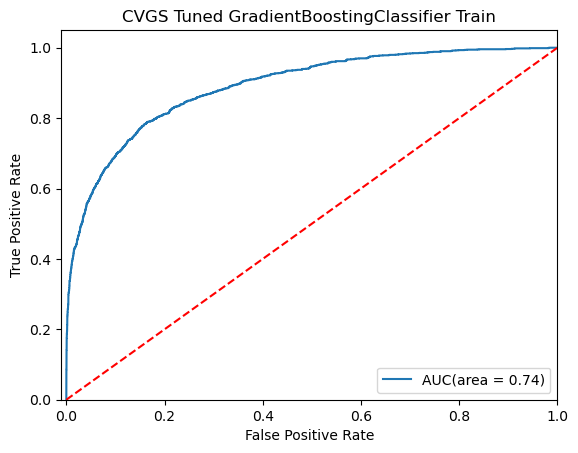

In [314]:
CVGS_gB_roc_train = roc_auc("CVGS Tuned GradientBoostingClassifier Train", customers_y_Train, CVGS_pred_gB_Class_Train, CVGS_pred_gB_Class_Train_proba)

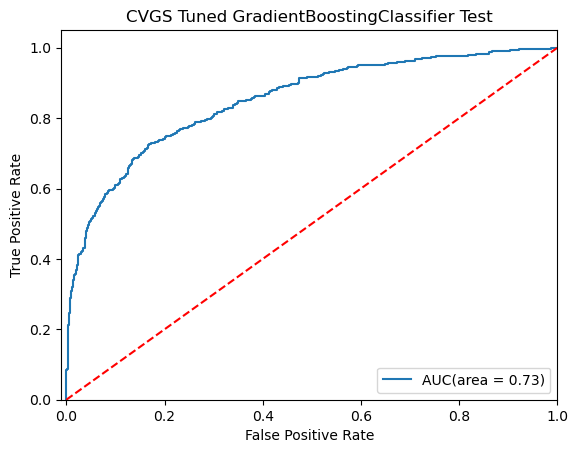

In [315]:
CVGS_gB_roc_test = roc_auc("CVGS Tuned GradientBoostingClassifier Test", customers_y_Test, CVGS_pred_gB_Class_Test, CVGS_pred_gB_Class_Test_proba)

# 5.Extreme Gradient Boosting Classifier
&ensp;<sup>[İçeriğe git.](#İçerik)</sup>

In [322]:
xGBoost_Class = XGBClassifier(random_state=121521014).fit(customers_X_Train, customers_y_Train)

Tahminleri ve olasılık tahminlerini alıyorum.

In [323]:
y_pred_xGBoost_Class_Train = xGBoost_Class.predict(customers_X_Train)
y_pred_xGBoost_Class_Test = xGBoost_Class.predict(customers_X_Test)

y_pred_xGBoost_Class_Train_proba = xGBoost_Class.predict_proba(customers_X_Train)
y_pred_xGBoost_Class_Test_proba = xGBoost_Class.predict_proba(customers_X_Test)

In [324]:
xGBoost_cf_train = confusion_matrix(customers_y_Train, y_pred_xGBoost_Class_Train)
xGBoost_cf_test = confusion_matrix(customers_y_Test, y_pred_xGBoost_Class_Test)

In [331]:
print(" "*5 , "XGBClassifier")
xGBoost_cf = confusion_matrices(xGBoost_cf_train, xGBoost_cf_test)

      XGBClassifier
 Train confusion matrix:
       0     1
0  6327    48
1   328  1297 
 Test confusion matrix:
       0    1
0  1493   95
1   214  198


In [332]:
xGBoost_acc_train = accuracy_score(customers_y_Train, y_pred_xGBoost_Class_Train)
xGBoost_acc_test = accuracy_score(customers_y_Test, y_pred_xGBoost_Class_Test)

In [336]:
print("", "GradientBoostingClassifier")
xGBoost_acc = accuracy_scores(xGBoost_acc_train, xGBoost_acc_test)

 GradientBoostingClassifier
 Train accuracy score: 0.953 
 Test accuracy score: 0.8455


Overfit durumu vardır.

In [337]:
print("\t"*2, "GradientBoostingClassifier Train")
xGBoost_report_train = classification_reports(customers_y_Train, y_pred_xGBoost_Class_Train)

		 GradientBoostingClassifier Train
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      6375
           1       0.96      0.80      0.87      1625

    accuracy                           0.95      8000
   macro avg       0.96      0.90      0.92      8000
weighted avg       0.95      0.95      0.95      8000



Test seti performansı kötüdür. Kaybedilen müşterileri doğru tahmin etmede rastgele tahminden daha düşük bir performansa sahiptir.

In [338]:
print("\t"*2, "GradientBoostingClassifier Test")
xGBoost_report_test = classification_reports(customers_y_Test, y_pred_xGBoost_Class_Test)

		 GradientBoostingClassifier Test
              precision    recall  f1-score   support

           0       0.87      0.94      0.91      1588
           1       0.68      0.48      0.56       412

    accuracy                           0.85      2000
   macro avg       0.78      0.71      0.73      2000
weighted avg       0.83      0.85      0.84      2000



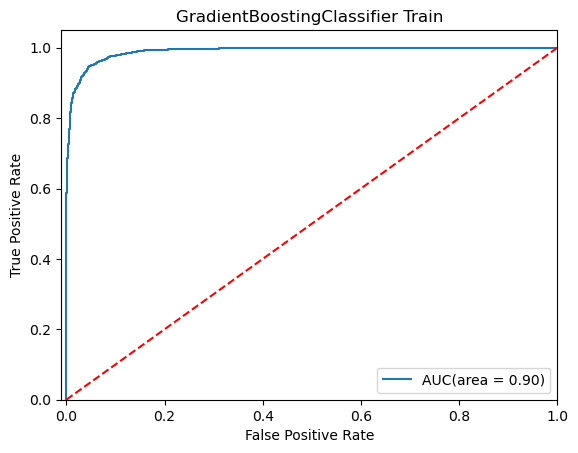

In [285]:
xGBoost_roc_train = roc_auc("GradientBoostingClassifier Train", customers_y_Train, y_pred_xGBoost_Class_Train, y_pred_xGBoost_Class_Train_proba)

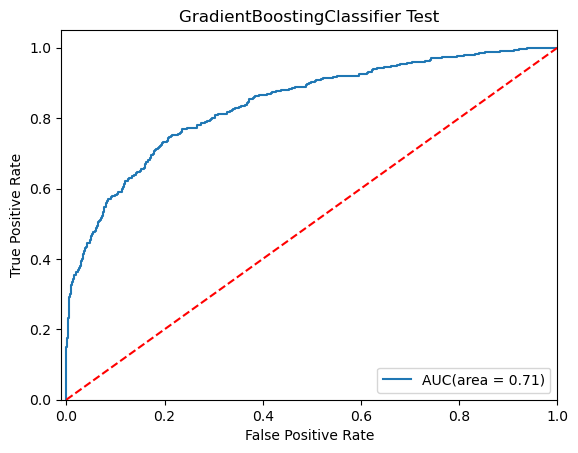

In [286]:
xGBoost_roc_test = roc_auc("GradientBoostingClassifier Test", customers_y_Test, y_pred_xGBoost_Class_Test, y_pred_xGBoost_Class_Test_proba)

#### 5.1.Grid Search Cross Validation
&nbsp;<sup>[İçeriğe git.](#İçerik)</sup>

XGBClassifier hiperparametrelerinden bazılarını belirliyorum.

In [340]:
#?xGBoost_Class
xGBoost_Class_params = {"learning_rate":[0.0001, 0.001, 0.01],
                        "subsample":[0.6, 0.8, 1],
                        "n_estimators":[100, 500],
                        "max_depth": [3, 5, 7]}

In [341]:
xGBoostfCV = XGBClassifier(random_state=121521014)

En iyi parameterleri bulmak için 5 foldluk bir GridSearch yapıyorum.

In [342]:
xGBoost_Class_CVGS = GridSearchCV(xGBoostfCV, 
                                  xGBoost_Class_params,
                                  cv=5,
                                  n_jobs=-1,
                                  verbose=2).fit(customers_X_Train, customers_y_Train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [343]:
xGBoost_Class_CVGS.best_params_, xGBoost_Class_CVGS.best_score_

({'learning_rate': 0.01,
  'max_depth': 7,
  'n_estimators': 500,
  'subsample': 0.8},
 0.868125)

En iyi olarak seçilen parametrelerle yeniden model kuruyorum.

In [344]:
xGBoost_Class_CVGS_tuned = XGBClassifier(random_state=121521014,
                                         learning_rate=xGBoost_Class_CVGS.best_params_["learning_rate"],
                                         n_estimators=xGBoost_Class_CVGS.best_params_["n_estimators"],
                                         subsample=xGBoost_Class_CVGS.best_params_["subsample"],
                                         max_depth=xGBoost_Class_CVGS.best_params_["max_depth"]).fit(customers_X_Train, customers_y_Train)

Tahminleri ve olasılık tahminlerini alıyorum.

In [345]:
CVGS_pred_xGBoost_Class_Train = xGBoost_Class_CVGS_tuned.predict(customers_X_Train)
CVGS_pred_xGBoost_Class_Test = gB_Class_CVGS_tuned.predict(customers_X_Test)

CVGS_pred_xGBoost_Class_Train_proba = xGBoost_Class_CVGS_tuned.predict_proba(customers_X_Train)
CVGS_pred_xGBoost_Class_Test_proba = xGBoost_Class_CVGS_tuned.predict_proba(customers_X_Test)

In [346]:
CVGS_xGBoost_cf_train = confusion_matrix(customers_y_Train, CVGS_pred_xGBoost_Class_Train)
CVGS_xGBoost_cf_test = confusion_matrix(customers_y_Test, CVGS_pred_xGBoost_Class_Test)

In [347]:
print("", "CVGS Tuned XGBClassifier")
CVGS_xGBoost_cf = confusion_matrices(CVGS_xGBoost_cf_train, CVGS_xGBoost_cf_test)

 CVGS Tuned XGBClassifier
 Train confusion matrix:
       0    1
0  6260  115
1   671  954 
 Test confusion matrix:
       0    1
0  1518   70
1   208  204


In [348]:
CVGS_xGBoost_acc_train = accuracy_score(customers_y_Train, CVGS_pred_xGBoost_Class_Train)
CVGS_xGBoost_acc_test = accuracy_score(customers_y_Test, CVGS_pred_xGBoost_Class_Test)

In [349]:
print("\t", "CVGS Tuned XGBClassifier")
xGBoost_acc = accuracy_scores(CVGS_xGBoost_acc_train, CVGS_xGBoost_acc_test)

	 CVGS Tuned XGBClassifier
 Train accuracy score: 0.90175 
 Test accuracy score: 0.861


Model tune edildiğinde overfit durumu ortadan kalktı fakat kaybedilen müşterilerin doğru tahmin edilme oranı oldukça düşük.

In [350]:
print("\t"*2, "CVGS Tuned XGBClassifier Train")
CVGS_xGBoost_report_train = classification_reports(customers_y_Train, CVGS_pred_xGBoost_Class_Train)

		 CVGS Tuned XGBClassifier Train
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      6375
           1       0.89      0.59      0.71      1625

    accuracy                           0.90      8000
   macro avg       0.90      0.78      0.82      8000
weighted avg       0.90      0.90      0.89      8000



Test setinde, kaybedilen müşterilerin doğru tahmin edilme oranı oldukça düşük fakat model performansı çok az iyileşmiştir.

In [351]:
print("\t"*2, "CVGS Tuned XGBClassifier Test")
CVGS_xGBoost_report_test = classification_reports(customers_y_Test, CVGS_pred_xGBoost_Class_Test)

		 CVGS Tuned XGBClassifier Test
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1588
           1       0.74      0.50      0.59       412

    accuracy                           0.86      2000
   macro avg       0.81      0.73      0.76      2000
weighted avg       0.85      0.86      0.85      2000



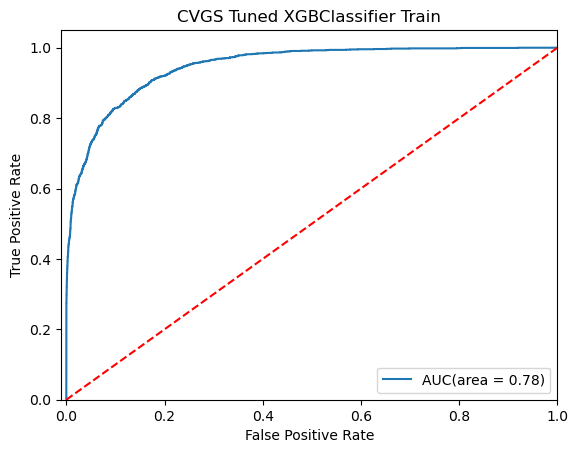

In [352]:
CVGS_xGBoost_roc_train = roc_auc("CVGS Tuned XGBClassifier Train", customers_y_Train, CVGS_pred_xGBoost_Class_Train, CVGS_pred_xGBoost_Class_Train_proba)

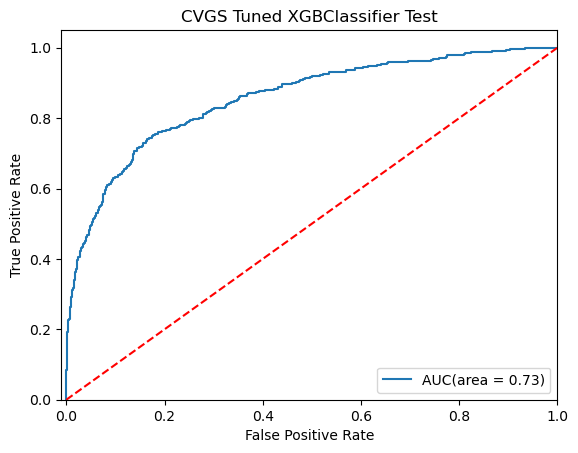

In [353]:
CVGS_xGBoost_roc_test = roc_auc("CVGS Tuned XGBClassifier Test", customers_y_Test, CVGS_pred_xGBoost_Class_Test, CVGS_pred_xGBoost_Class_Test_proba)

-------------------------------------------------------------------------------------------------------

Test seti performanslarına bakarsak MLPClassifier, tune edilmiş XGBClassifier ve tune edilmiş GradientBoostingClassifier performansları birbirine yakın ve modeller arasında en iyileridir.  
Genel olarak görülen problem, kaybedilen müşterilerin sayısının azlığından kaynaklı olarak bu durumun doğru tahmin edilemesidir.  
Bu üç modele bakacak olursak, kaybedilen müşterilerin doğru tahmin edilme oranının yaklaşık %50 olduğu görülüyor. Yani rastgele tahminde bulunmakla aynı performansa sahip fakat ayrılacağı tahmin edilen müşterilerin gerçekten kaybedilme oranı yaklaşık %75'dir. Kötü bir değer değil.

In [354]:
print("\t"*3, "MLPClassifier Test")
aNN_report_test = classification_reports(customers_y_Test, y_pred_aNN_Class_Test)

		 CVGS Tuned MLPClassifier Train
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      6375
           1       0.77      0.52      0.62      1625

    accuracy                           0.87      8000
   macro avg       0.83      0.74      0.77      8000
weighted avg       0.86      0.87      0.86      8000



In [355]:
print("\t"*2, "CVGS Tuned XGBClassifier Test")
CVGS_xGBoost_report_test = classification_reports(customers_y_Test, CVGS_pred_xGBoost_Class_Test)

		 CVGS Tuned XGBClassifier Test
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1588
           1       0.74      0.50      0.59       412

    accuracy                           0.86      2000
   macro avg       0.81      0.73      0.76      2000
weighted avg       0.85      0.86      0.85      2000



In [356]:
print(" "*11, "CVGS Tuned GradientBoostingClassifier Test")
CVGS_gB_report_test = classification_reports(customers_y_Test, CVGS_pred_gB_Class_Test)

            CVGS Tuned GradientBoostingClassifier Test
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1588
           1       0.74      0.50      0.59       412

    accuracy                           0.86      2000
   macro avg       0.81      0.73      0.76      2000
weighted avg       0.85      0.86      0.85      2000

